# In-situ Gel Treatment Prediction 

In this project, we use supervised learning models to identify when and where in-situ gel can be effective for conformance control. Furthermore, we will analyze top factors that influence the treatment result. [Dataset information](https://docs.google.com/spreadsheets/d/1xpFILBRuhmnOE3RRd39j9kSzb8eNWv7L/edit?usp=sharing&ouid=117836167977540402507&rtpof=true&sd=true).

## Contents


* [Part 1: Data Exploration](#Part-1:-Data-Exploration)
* [Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
* [Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)

# Part 0: Setup Google Drive Environment / Data Collection
check this [link](https://colab.research.google.com/notebooks/io.ipynb) for more info

In [3]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# the same way we get id from last class
#https://drive.google.com/file/d/1GUAcSWHDws8BAP2a-3sBytIrEVWQzLAs/view?usp=sharing
#d/后面到/view 这段是id
#查看是否导入成功可以看看左边状态栏第五个打开file看是否有这个file.csv
id = "1GUAcSWHDws8BAP2a-3sBytIrEVWQzLAs"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('In-situ_Gel_Optimization.csv') #取文件并且命名

In [5]:
import pandas as pd
df = pd.read_csv('In-situ_Gel_Optimization.csv')
df.head()

,ID,Channel_Thickness,FREQFAC,Gelation_Time,Frr,Gel_Initiate_Time(WC),Gelant_Rate,K_Ratio,Oil_Viscosity,Gelant_Viscosity,SHEARTHIN,Profile Reduction
0,1.0,3.981072,1.892871,0.528298,26896.8,0.70,1589.29,256470.0,251.188640,1683.089,0.362,0.799753386
1,2.0,100.000000,0.475467,2.103194,41716.0,0.90,1776.05,500490.0,39.810717,588.143,0.527,0.760233072
2,3.0,15.848932,0.119432,8.372973,26896.8,0.75,2336.33,256470.0,63.095734,1865.580,0.461,0.517429481
3,4.0,10.000000,0.189287,5.282988,41716.0,0.75,2336.33,12450.0,630.957340,770.634,0.362,0.681004906
4,5.0,63.095734,0.475467,2.103194,63944.8,0.95,842.25,12450.0,630.957340,1683.089,0.296,0.73629408


# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [6]:
import pandas as pd
import numpy as np

ISG_df = pd.read_csv('In-situ_Gel_Optimization.csv')

In [7]:
ISG_df.head()

,ID,Channel_Thickness,FREQFAC,Gelation_Time,Frr,Gel_Initiate_Time(WC),Gelant_Rate,K_Ratio,Oil_Viscosity,Gelant_Viscosity,SHEARTHIN,Profile Reduction
0,1.0,3.981072,1.892871,0.528298,26896.8,0.70,1589.29,256470.0,251.188640,1683.089,0.362,0.799753386
1,2.0,100.000000,0.475467,2.103194,41716.0,0.90,1776.05,500490.0,39.810717,588.143,0.527,0.760233072
2,3.0,15.848932,0.119432,8.372973,26896.8,0.75,2336.33,256470.0,63.095734,1865.580,0.461,0.517429481
3,4.0,10.000000,0.189287,5.282988,41716.0,0.75,2336.33,12450.0,630.957340,770.634,0.362,0.681004906
4,5.0,63.095734,0.475467,2.103194,63944.8,0.95,842.25,12450.0,630.957340,1683.089,0.296,0.73629408


In [8]:
ISG_df['Channel_Thickness']=ISG_df['Channel_Thickness']/(999+ISG_df['Channel_Thickness'])


In [9]:
lower, upper = 0.1, 2
l_norm = [lower + (upper - lower) * (x-1/3)/(1/0.03-1/3) for x in (1/ISG_df['FREQFAC'])]


In [10]:
ISG_df['Gelation_Time']=l_norm

ISG_df['Gelation_Time']
print(max(ISG_df['Gelation_Time']))


2.000005565672706


In [11]:
del ISG_df['FREQFAC']

In [12]:
ISG_df.head()

,ID,Channel_Thickness,Gelation_Time,Frr,Gel_Initiate_Time(WC),Gelant_Rate,K_Ratio,Oil_Viscosity,Gelant_Viscosity,SHEARTHIN,Profile Reduction
0,1.0,0.003969,0.111225,26896.8,0.70,1589.29,256470.0,251.188640,1683.089,0.362,0.799753386
1,2.0,0.090992,0.201901,41716.0,0.90,1776.05,500490.0,39.810717,588.143,0.527,0.760233072
2,3.0,0.015617,0.562888,26896.8,0.75,2336.33,256470.0,63.095734,1865.580,0.461,0.517429481
3,4.0,0.009911,0.384980,41716.0,0.75,2336.33,12450.0,630.957340,770.634,0.362,0.681004906
4,5.0,0.059407,0.201901,63944.8,0.95,842.25,12450.0,630.957340,1683.089,0.296,0.73629408


In [13]:
ISG_df['Gel_Initiate_Time(WC)']=ISG_df['Gel_Initiate_Time(WC)']*100


In [14]:
b=ISG_df['Profile Reduction']
b[b=='None']=None
b=='None'
ISG_df['Profile Reduction']=b

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
ISG_df['Profile Reduction']=pd.to_numeric(ISG_df['Profile Reduction'])


In [16]:
TreatmentResult=pd.Series(np.zeros(len(ISG_df['Profile Reduction'])))


In [17]:
numReduction=ISG_df['Profile Reduction']
sum(numReduction>0.8)

33

In [18]:

for i in range(len(numReduction)):
  if numReduction[i]<0.3:
    TreatmentResult[i]='Less Effective'
  elif 0.8>numReduction[i]>0.3:
    TreatmentResult[i]='Effective'
  elif numReduction[i]>0.8:
    TreatmentResult[i]='Very Effective'
  else:
    TreatmentResult[i]='Simulation Failed'



In [19]:
ISG_df['Treatment Result']=TreatmentResult


In [20]:
# check data info
ISG_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     86 non-null     float64
 1   Channel_Thickness      86 non-null     float64
 2   Gelation_Time          86 non-null     float64
 3   Frr                    86 non-null     float64
 4   Gel_Initiate_Time(WC)  86 non-null     float64
 5   Gelant_Rate            86 non-null     float64
 6   K_Ratio                86 non-null     float64
 7   Oil_Viscosity          86 non-null     float64
 8   Gelant_Viscosity       86 non-null     float64
 9   SHEARTHIN              86 non-null     float64
 10  Profile Reduction      82 non-null     float64
 11  Treatment Result       88 non-null     object 
dtypes: float64(11), object(1)
memory usage: 8.4+ KB


In [21]:
# check the number of unique values for each column
# 前两个变量基本没有意义因为全是unique value推不出pattern
ISG_df.nunique()


ID                       86
Channel_Thickness        19
Gelation_Time            19
Frr                      19
Gel_Initiate_Time(WC)    19
Gelant_Rate              19
K_Ratio                  19
Oil_Viscosity            19
Gelant_Viscosity         19
SHEARTHIN                19
Profile Reduction        82
Treatment Result          4
dtype: int64

In [22]:
del ISG_df['ID']

In [23]:
# Get target variable
y = ISG_df['Profile Reduction']

### Part 1.2:  Understand the features

In [24]:
# check missing values
ISG_df.isnull().sum()

Channel_Thickness        2
Gelation_Time            2
Frr                      2
Gel_Initiate_Time(WC)    2
Gelant_Rate              2
K_Ratio                  2
Oil_Viscosity            2
Gelant_Viscosity         2
SHEARTHIN                2
Profile Reduction        6
Treatment Result         0
dtype: int64

In [25]:
nanrow=ISG_df.isnull()
row_has_NaN = nanrow.any(axis=1)
rows_with_NaN = df[row_has_NaN]

In [26]:
rows_with_NaN

,ID,Channel_Thickness,FREQFAC,Gelation_Time,Frr,Gel_Initiate_Time(WC),Gelant_Rate,K_Ratio,Oil_Viscosity,Gelant_Viscosity,SHEARTHIN,Profile Reduction
5,6.0,6.309573,0.03,33.33343,41716.0,0.900,2336.33,195465.0,15.848932,1500.598,0.527,None
15,16.0,39.810717,0.03,33.33343,56535.2,0.925,1776.05,12450.0,158.489320,1865.580,0.395,None
27,28.0,25.118864,0.03,33.33343,41716.0,0.800,2709.85,561495.0,39.810717,953.125,0.362,None
85,86.0,15.848932,0.03,33.33343,41716.0,0.800,2709.85,500490.0,100.000000,1865.580,0.362,None
86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
ISG_df.dropna(inplace=True)

In [28]:
# understand Numerical feature
# discrete/continuous
# 'CreditScore', 'Age', 'Tenure', 'NumberOfProducts'
# 'Balance', 'EstimatedSalary'
# 可以看出estimatedsalary的min 是 11.58 非常奇怪，一年才11块多，应咨询面试官是否需要提供threshold line，这样可以去掉例如2w以下用户
ISG_df.describe()

,Channel_Thickness,Gelation_Time,Frr,Gel_Initiate_Time(WC),Gelant_Rate,K_Ratio,Oil_Viscosity,Gelant_Viscosity,SHEARTHIN,Profile Reduction
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,0.024751,0.460154,40935.654744,82.665003,1766.402855,323272.392841,250.338102,975.155826,0.397522,0.654596
std,0.028592,0.498177,24049.916901,7.773551,579.334192,191358.954132,308.936997,562.755045,0.104656,0.291137
min,0.001000,0.100000,4668.000000,70.000000,842.250000,12450.000000,10.000000,40.670000,0.230000,-0.021756
25%,0.002508,0.129016,19487.200000,75.625000,1215.770000,195465.000000,25.118864,451.274750,0.296000,0.529533
50%,0.009911,0.215062,38011.200000,82.500000,1776.050000,317475.000000,100.000000,953.125000,0.395000,0.777106
75%,0.038323,0.562888,63944.800000,89.836529,2215.878475,500490.000000,398.107170,1483.761900,0.494000,0.855555
max,0.090992,2.000006,78764.000000,95.000000,2709.850000,622500.000000,1000.000000,1865.580000,0.560000,0.999705


In [29]:
# check the feature distribution
# pandas.DataFrame.describe()
# boxplot, distplot, countplot
import matplotlib.pyplot as plt
import seaborn as sns

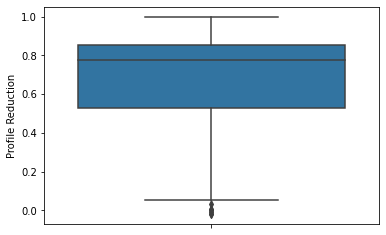

In [30]:
sns.boxplot(y='Profile Reduction',data=ISG_df)

In [31]:
ISG_df.rename(columns={'SHEARTHIN': 'Shearthin'}, inplace=True)
ISG_df.rename(columns={'Gelation_Time': 'Gelation_Time(Relative)'}, inplace=True)

In [32]:
ISG_df.sort_values(by='Treatment Result',ascending=False,inplace=True)

In [33]:
ISG_df.head()

,Channel_Thickness,Gelation_Time(Relative),Frr,Gel_Initiate_Time(WC),Gelant_Rate,K_Ratio,Oil_Viscosity,Gelant_Viscosity,Shearthin,Profile Reduction,Treatment Result
60,0.090992,0.384980,63944.8,95.0,2709.85,256470.0,398.107170,1683.089,0.329,0.897814,Very Effective
30,0.024527,1.291740,34306.4,72.5,2336.33,134460.0,158.489320,1135.616,0.395,0.991745,Very Effective
23,0.009911,0.129016,78764.0,77.5,1215.77,378480.0,15.848932,953.125,0.296,0.880406,Very Effective
24,0.015617,0.562888,71354.4,82.5,2523.09,378480.0,10.000000,1135.616,0.527,0.853976,Very Effective
75,0.001584,0.129016,63944.8,70.0,842.25,439485.0,100.000000,1318.107,0.296,0.846425,Very Effective


In [34]:
ISG_df.rename(columns={'Channel_Thickness':'Channel_Relative_Thickness'},inplace=True)

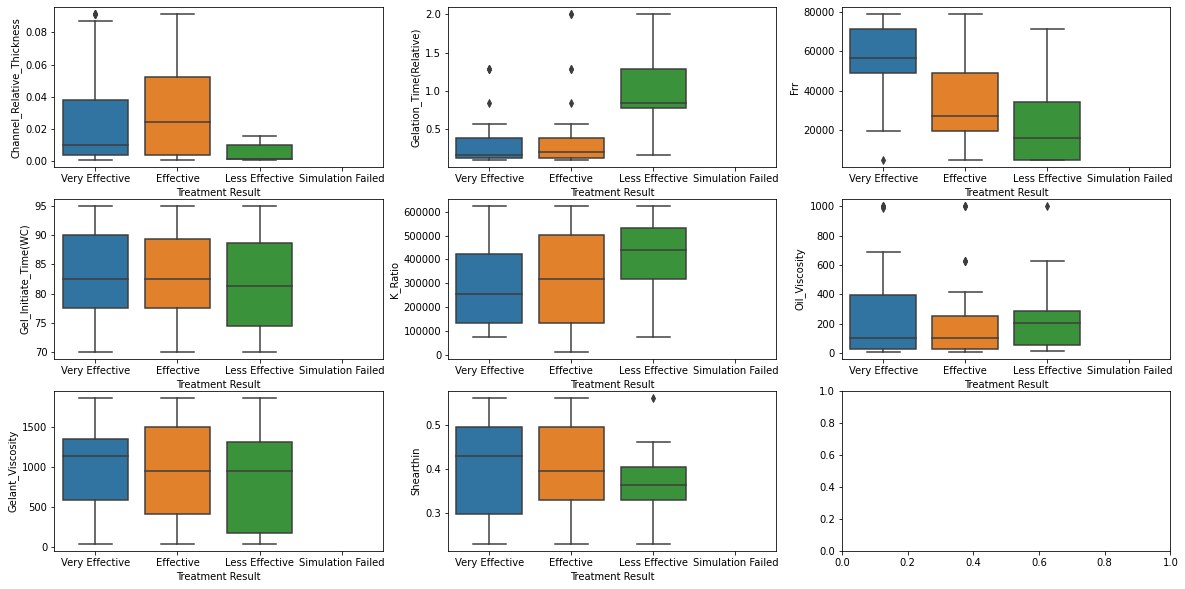

In [35]:
# boxplot for numerical feature
_,axss = plt.subplots(3,3, figsize=[20,10])
sns.boxplot(x='Treatment Result', y ='Channel_Relative_Thickness', data=ISG_df, order=['Very Effective','Effective','Less Effective','Simulation Failed'], ax=axss[0][0])
sns.boxplot(x='Treatment Result', y ='Gelation_Time(Relative)', data=ISG_df, order=['Very Effective','Effective','Less Effective','Simulation Failed'], ax=axss[0][1])
sns.boxplot(x='Treatment Result', y ='Frr', data=ISG_df, order=['Very Effective','Effective','Less Effective','Simulation Failed'], ax=axss[0][2])
sns.boxplot(x='Treatment Result', y ='Gel_Initiate_Time(WC)', data=ISG_df, order=['Very Effective','Effective','Less Effective','Simulation Failed'], ax=axss[1][0])
sns.boxplot(x='Treatment Result', y ='K_Ratio', data=ISG_df, order=['Very Effective','Effective','Less Effective','Simulation Failed'], ax=axss[1][1])
sns.boxplot(x='Treatment Result', y ='Oil_Viscosity', data=ISG_df, order=['Very Effective','Effective','Less Effective','Simulation Failed'], ax=axss[1][2])
sns.boxplot(x='Treatment Result', y ='Gelant_Viscosity', data=ISG_df, order=['Very Effective','Effective','Less Effective','Simulation Failed'], ax=axss[2][0])
sns.boxplot(x='Treatment Result', y ='Shearthin', data=ISG_df, order=['Very Effective','Effective','Less Effective','Simulation Failed'], ax=axss[2][1])


#可以根据每个图对比提出hyposises，后续可以进行验证

# Part 2: Feature Preprocessing

In [36]:
ISG_df.head()


,Channel_Relative_Thickness,Gelation_Time(Relative),Frr,Gel_Initiate_Time(WC),Gelant_Rate,K_Ratio,Oil_Viscosity,Gelant_Viscosity,Shearthin,Profile Reduction,Treatment Result
60,0.090992,0.384980,63944.8,95.0,2709.85,256470.0,398.107170,1683.089,0.329,0.897814,Very Effective
30,0.024527,1.291740,34306.4,72.5,2336.33,134460.0,158.489320,1135.616,0.395,0.991745,Very Effective
23,0.009911,0.129016,78764.0,77.5,1215.77,378480.0,15.848932,953.125,0.296,0.880406,Very Effective
24,0.015617,0.562888,71354.4,82.5,2523.09,378480.0,10.000000,1135.616,0.527,0.853976,Very Effective
75,0.001584,0.129016,63944.8,70.0,842.25,439485.0,100.000000,1318.107,0.296,0.846425,Very Effective


In [37]:
# Get feature space by dropping useless feature
to_drop = ['Profile Reduction','Treatment Result']
X = ISG_df.drop(to_drop, axis=1)

In [38]:
X.head()

,Channel_Relative_Thickness,Gelation_Time(Relative),Frr,Gel_Initiate_Time(WC),Gelant_Rate,K_Ratio,Oil_Viscosity,Gelant_Viscosity,Shearthin
60,0.090992,0.384980,63944.8,95.0,2709.85,256470.0,398.107170,1683.089,0.329
30,0.024527,1.291740,34306.4,72.5,2336.33,134460.0,158.489320,1135.616,0.395
23,0.009911,0.129016,78764.0,77.5,1215.77,378480.0,15.848932,953.125,0.296
24,0.015617,0.562888,71354.4,82.5,2523.09,378480.0,10.000000,1135.616,0.527
75,0.001584,0.129016,63944.8,70.0,842.25,439485.0,100.000000,1318.107,0.296


In [39]:
X.dtypes

Channel_Relative_Thickness    float64
Gelation_Time(Relative)       float64
Frr                           float64
Gel_Initiate_Time(WC)         float64
Gelant_Rate                   float64
K_Ratio                       float64
Oil_Viscosity                 float64
Gelant_Viscosity              float64
Shearthin                     float64
dtype: object

In [40]:
cat_cols = X.columns[X.dtypes == 'O']#categorical type is 0
num_cols = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64')]

In [41]:
num_cols

Index(['Channel_Relative_Thickness', 'Gelation_Time(Relative)', 'Frr',
       'Gel_Initiate_Time(WC)', 'Gelant_Rate', 'K_Ratio', 'Oil_Viscosity',
       'Gelant_Viscosity', 'Shearthin'],
      dtype='object')

In [42]:
cat_cols

Index([], dtype='object')

#Split dataset
#应该先分数据，再进行preprocessing，因为testing set数据尽量不要动


In [43]:
# Objective: y is Treatment Result
y=ISG_df['Treatment Result']

In [44]:
# Splite data into training and testing
# 100 -> 75:y=1, 25:y=0
# training(80): 60 y=1; 20 y=0 
# testing(20):  15 y=1; 5 y=0

from sklearn import model_selection

# Reserve 25% for testing
# stratify example:
# 100 -> y: 80 '0', 20 '1' -> 4:1
# 80% training 64: '0', 16:'1' -> 4:1
# 20% testing  16:'0', 4: '1' -> 4:1
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify = y, random_state=1) #stratify = y :=> stratified sampling 分层抽样 根据y的分类进行分层然后随机抽样

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 65 observation with 9 features
test data has 17 observation with 9 features


* 10000 -> 8000 '0' + 2000 '1'

* 25% test 75% training 
---
without stratified sampling:
• extreme case:
---
1. testing: 2000 '1' + 500 '0'
2. training: 7500 '0'
---
with stratified sampling:
1. testing: 2000 '0' + 500 '1'
2. training: 6000 '0' + 1500 '1'


Read more for handling [categorical feature](https://github.com/scikit-learn-contrib/categorical-encoding), and there is an awesome package for [encoding](http://contrib.scikit-learn.org/category_encoders/).

In [45]:
X_train.head()

,Channel_Relative_Thickness,Gelation_Time(Relative),Frr,Gel_Initiate_Time(WC),Gelant_Rate,K_Ratio,Oil_Viscosity,Gelant_Viscosity,Shearthin
35,0.009911,0.844854,12077.6,80.0,1402.53,317475.0,39.810717,1318.107,0.560
23,0.009911,0.129016,78764.0,77.5,1215.77,378480.0,15.848932,953.125,0.296
32,0.001000,0.844854,71354.4,75.0,1029.01,622500.0,158.489320,770.634,0.395
38,0.006276,1.291740,56535.2,85.0,2336.33,622500.0,1000.000000,770.634,0.494
48,0.002508,0.384980,12077.6,87.5,1215.77,256470.0,1000.000000,405.652,0.494


In [46]:
X_train.head()

,Channel_Relative_Thickness,Gelation_Time(Relative),Frr,Gel_Initiate_Time(WC),Gelant_Rate,K_Ratio,Oil_Viscosity,Gelant_Viscosity,Shearthin
35,0.009911,0.844854,12077.6,80.0,1402.53,317475.0,39.810717,1318.107,0.560
23,0.009911,0.129016,78764.0,77.5,1215.77,378480.0,15.848932,953.125,0.296
32,0.001000,0.844854,71354.4,75.0,1029.01,622500.0,158.489320,770.634,0.395
38,0.006276,1.291740,56535.2,85.0,2336.33,622500.0,1000.000000,770.634,0.494
48,0.002508,0.384980,12077.6,87.5,1215.77,256470.0,1000.000000,405.652,0.494


In [47]:
X_train.head()

,Channel_Relative_Thickness,Gelation_Time(Relative),Frr,Gel_Initiate_Time(WC),Gelant_Rate,K_Ratio,Oil_Viscosity,Gelant_Viscosity,Shearthin
35,0.009911,0.844854,12077.6,80.0,1402.53,317475.0,39.810717,1318.107,0.560
23,0.009911,0.129016,78764.0,77.5,1215.77,378480.0,15.848932,953.125,0.296
32,0.001000,0.844854,71354.4,75.0,1029.01,622500.0,158.489320,770.634,0.395
38,0.006276,1.291740,56535.2,85.0,2336.33,622500.0,1000.000000,770.634,0.494
48,0.002508,0.384980,12077.6,87.5,1215.77,256470.0,1000.000000,405.652,0.494


Standardize/Normalize Data

In [48]:
# Scale the data, using standardization
# standardization (x-mean)/std
# normalization (x-x_min)/(x_max-x_min) ->[0,1]

# 1. speed up gradient descent
# 2. same scale
# 3. algorithm requirments

# for example, use training data to train the standardscaler to get mean and std 
# apply mean and std to both training and testing data.
# fit_transform does the training and applying, transform only does applying.
# Because we can't use any info from test, and we need to do the same modification
# to testing data as well as training data

# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
# https://scikit-learn.org/stable/modules/preprocessing.html


# min-max example: (x-x_min)/(x_max-x_min)
# [1,2,3,4,5,6,100] -> fit(min:1, max:6) (scalar.min = 1, scalar.max = 6) -> transform [(1-1)/(6-1),(2-1)/(6-1)..]
# scalar.fit(train) -> min:1, max:100
# scalar.transform(apply to x) -> apply min:1, max:100 to X_train
# scalar.transform -> apply min:1, max:100 to X_test

# scalar.fit -> mean:1, std:100
# scalar.transform -> apply mean:1, std:100 to X_train
# scalar.transform -> apply mean:1, std:100 to X_test

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Part 3: Model Training and Result Evaluation

### Part 3.1: Model Training

In [49]:
#@title build models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

In [50]:
# Train the model
classifier_logistic.fit(X_train, y_train)

LogisticRegression()

In [51]:
# Prediction of test data
classifier_logistic.predict(X_test)

array(['Effective', 'Very Effective', 'Effective', 'Effective',
       'Effective', 'Effective', 'Very Effective', 'Effective',
       'Effective', 'Effective', 'Effective', 'Effective',
       'Very Effective', 'Effective', 'Effective', 'Effective',
       'Effective'], dtype=object)

In [52]:
# Accuracy of test data
classifier_logistic.score(X_test, y_test)

0.6470588235294118

In [53]:
# Use 5-fold Cross Validation to get the accuracy for different models
model_names = ['Logistic Regression','KNN','Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=5)
    print(cv_score)
    print('Model accuracy of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    count += 1

[0.38461538 0.69230769 0.46153846 0.76923077 0.61538462]
Model accuracy of Logistic Regression is 0.5846153846153845
[0.46153846 0.38461538 0.61538462 0.46153846 0.61538462]
Model accuracy of KNN is 0.5076923076923078
[0.46153846 0.69230769 0.76923077 0.76923077 0.53846154]
Model accuracy of Random Forest is 0.6461538461538461


### (Optional) Part 3.2: Use Grid Search to Find Optimal Hyperparameters
alternative: random search

In [54]:
#Loss/cost function --> (wx + b - y) ^2 + ƛ * |w| --> ƛ is a hyperparameter

In [55]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

#### Part 3.2.1: Find Optimal Hyperparameters - LogisticRegression

In [56]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the 1/lambda value(weight) for L1 and L2
# solver: algorithm to find the weights that minimize the cost function

# ('l1', 0.01)('l1', 0.05) ('l1', 0.1) ('l1', 0.2)('l1', 1)
# ('12', 0.01)('l2', 0.05) ('l2', 0.1) ('l2', 0.2)('l2', 1)
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(0.2, 1, 1.5, 2) #一般来说从0.1左右开始试
}

Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv=5) #有些算法solver不支持l1，需要查function detail
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': (0.2, 1, 1.5, 2), 'penalty': ('l1', 'l2')})

In [57]:
# the best hyperparameter combination
# C = 1/lambda
print_grid_search_metrics(Grid_LR)

Best score: 0.6307692307692307
Best parameters set:
C:0.2
penalty:l1


In [58]:
# best model
best_LR_model = Grid_LR.best_estimator_

In [59]:
best_LR_model.predict(X_test)

array(['Effective', 'Very Effective', 'Effective', 'Effective',
       'Very Effective', 'Effective', 'Very Effective', 'Effective',
       'Effective', 'Effective', 'Effective', 'Less Effective',
       'Very Effective', 'Effective', 'Effective', 'Effective',
       'Effective'], dtype=object)

In [60]:
best_LR_model.score(X_test, y_test)

0.6470588235294118

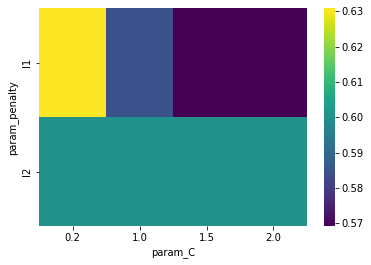

In [61]:
LR_models = pd.DataFrame(Grid_LR.cv_results_)
res = (LR_models.pivot(index='param_penalty', columns='param_C', values='mean_test_score')
            )
_ = sns.heatmap(res, cmap='viridis')

Best case suggests 1.5 as hyperparameter


#### Part 3.2.2: Find Optimal Hyperparameters: KNN

In [62]:
# Possible hyperparamter options for KNN
# Choose k
parameters = {
    'n_neighbors':[1,3,5,7,9]
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9]})

In [63]:
# best k
print_grid_search_metrics(Grid_KNN)

Best score: 0.5230769230769231
Best parameters set:
n_neighbors:1


Best case suggests 7

#调参目的是找到需要的model，不见得是最好的，能达到目的就行

In [64]:
best_KNN_model = Grid_KNN.best_estimator_

#### Part 3.2.3: Find Optimal Hyperparameters: Random Forest

In [65]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [50,51,52,53,54,55,57],
    'max_depth': [3,4,5,6,7,10]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 10],
                         'n_estimators': [50, 51, 52, 53, 54, 55, 57]})

In [66]:
# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.6923076923076923
Best parameters set:
max_depth:6
n_estimators:57


#最后发现10层深度，54个树model最佳

In [67]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

In [68]:
best_RF_model

RandomForestClassifier(max_depth=6, n_estimators=57)

####Part 3.3: Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)

class of interest as positive

TP: correctly labeled treatment result

Precision(PPV, positive predictive value): tp / (tp + fp);
Total number of true predictive treatment result divided by the total number of predictive result;
High Precision means low fp, not many return result were predicted as result. 


Recall(sensitivity, hit rate, true positive rate): tp / (tp + fn)
Predict most postive or treatment result correctly. High recall means low fn, not many treatment result were predicted correctly.

In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]+cm[1][1]
    fp = cm[0][1]+cm[0][2]+cm[1][2]
    fn = cm[1][0]+cm[2][1]+cm[2][0]
    tp = cm[2][2]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: " + str(accuracy))
    print ("precision is: " + str(precision))
    print ("recall is: " + str(recall))
    print (cm)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)

In [70]:
y_test

0          Effective
72    Very Effective
37    Less Effective
79         Effective
21    Very Effective
36    Less Effective
18    Very Effective
56    Very Effective
45    Very Effective
26         Effective
71         Effective
73         Effective
59    Very Effective
2          Effective
61         Effective
67         Effective
20    Very Effective
Name: Treatment Result, dtype: object

In [71]:
best_RF_model.predict(X_test)

array(['Effective', 'Very Effective', 'Effective', 'Effective',
       'Effective', 'Effective', 'Very Effective', 'Very Effective',
       'Effective', 'Effective', 'Effective', 'Effective', 'Effective',
       'Effective', 'Effective', 'Effective', 'Effective'], dtype=object)

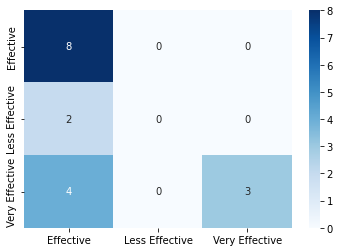

Random Forest
Accuracy is: 0.6470588235294118
precision is: 1.0
recall is: 0.3333333333333333
[[8 0 0]
 [2 0 0]
 [4 0 3]]
Logistic Regression
Accuracy is: 0.6470588235294118
precision is: 0.8
recall is: 0.4444444444444444
[[7 1 0]
 [2 0 0]
 [3 0 4]]
K nearest neighbor
Accuracy is: 0.47058823529411764
precision is: 0.5
recall is: 0.1111111111111111
[[7 1 0]
 [2 0 0]
 [4 2 1]]


In [72]:
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
    ("K nearest neighbor", confusion_matrix(y_test, best_KNN_model.predict(X_test)))
]
crf=confusion_matrix(y_test,best_RF_model.predict(X_test))
ytick=best_RF_model.predict(X_test)
sns.heatmap(crf,cmap='Blues',xticklabels=['Effective','Less Effective','Very Effective'],
            yticklabels=['Effective','Less Effective','Very Effective'],annot=True, fmt="d")
plt.show()
draw_confusion_matrices(confusion_matrices)


In [73]:
best_RF_model.predict(X_train)


array(['Less Effective', 'Very Effective', 'Less Effective', 'Effective',
       'Effective', 'Very Effective', 'Less Effective', 'Very Effective',
       'Effective', 'Effective', 'Very Effective', 'Effective',
       'Effective', 'Very Effective', 'Effective', 'Very Effective',
       'Very Effective', 'Less Effective', 'Less Effective', 'Effective',
       'Very Effective', 'Very Effective', 'Very Effective',
       'Very Effective', 'Less Effective', 'Very Effective', 'Effective',
       'Less Effective', 'Effective', 'Effective', 'Very Effective',
       'Effective', 'Very Effective', 'Very Effective', 'Effective',
       'Effective', 'Very Effective', 'Less Effective', 'Less Effective',
       'Effective', 'Very Effective', 'Very Effective', 'Effective',
       'Very Effective', 'Effective', 'Effective', 'Very Effective',
       'Effective', 'Effective', 'Effective', 'Very Effective',
       'Effective', 'Effective', 'Very Effective', 'Effective',
       'Effective', 'Effective',

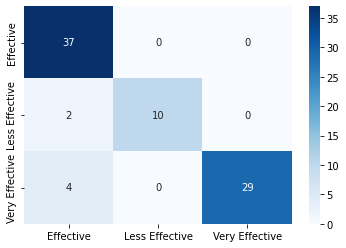

In [74]:
#Test for the whole data set
crf_train=confusion_matrix(y_train,best_RF_model.predict(X_train))
crf_test=confusion_matrix(y_test,best_RF_model.predict(X_test))
crf_all=crf_train+crf_test
sns.heatmap(crf_all,cmap='Blues',xticklabels=['Effective','Less Effective','Very Effective'],
            yticklabels=['Effective','Less Effective','Very Effective'],annot=True, fmt="d")
plt.show()

# Part 4: Model Extra Functionality

### Part 4.1:  Logistic Regression Model

The corelated features that we are interested in

### Part 4.2:  Random Forest Model - Feature Importance Discussion

In [80]:
X_RF = X.copy()

#X_RF = OneHotEncoding(X_RF, enc_ohe, ['Geography'])
#X_RF['Gender'] = enc_oe.transform(X_RF[['Gender']])

X_RF.head()

,Channel_Relative_Thickness,Gelation_Time(Relative),Frr,Gel_Initiate_Time(WC),Gelant_Rate,K_Ratio,Oil_Viscosity,Gelant_Viscosity,Shearthin
60,0.090992,0.384980,63944.8,95.0,2709.85,256470.0,398.107170,1683.089,0.329
30,0.024527,1.291740,34306.4,72.5,2336.33,134460.0,158.489320,1135.616,0.395
23,0.009911,0.129016,78764.0,77.5,1215.77,378480.0,15.848932,953.125,0.296
24,0.015617,0.562888,71354.4,82.5,2523.09,378480.0,10.000000,1135.616,0.527
75,0.001584,0.129016,63944.8,70.0,842.25,439485.0,100.000000,1318.107,0.296


In [81]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(X_RF, y)
bar_x=[]
bar_y=[]
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for ind in range(X.shape[1]):
  print ("{0} : {1}".format(X_RF.columns[indices[ind]],round(importances[indices[ind]], 4)))
  bar_x.append(round(importances[indices[ind]], 4))
  bar_y.append(X_RF.columns[indices[ind]])

Feature importance ranking by Random Forest Model:
Frr : 0.2351
Channel_Relative_Thickness : 0.1331
Gelation_Time(Relative) : 0.1316
K_Ratio : 0.123
Shearthin : 0.0835
Gelant_Viscosity : 0.0789
Gelant_Rate : 0.0784
Gel_Initiate_Time(WC) : 0.0754
Oil_Viscosity : 0.0609


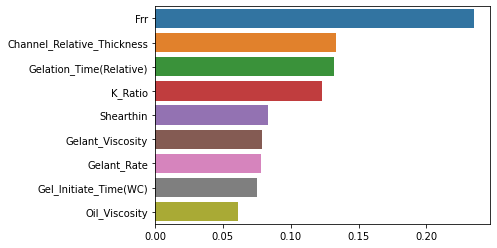

In [82]:
sns.barplot(x=bar_x,y=bar_y,orient='h')

#importance 仅对该RF model的相对重要性，只是提供参考

In [ ]:
import numpy
from sklearn.model_selection import train_test_split
from sklearn import metrics, datasets, ensemble

def print_decision_rules(rf):

    for tree_idx, est in enumerate(rf.estimators_):
        tree = est.tree_
        assert tree.value.shape[1] == 1 # no support for multi-output

        print('TREE: {}'.format(tree_idx))

        iterator = enumerate(zip(tree.children_left, tree.children_right, tree.feature, tree.threshold, tree.value))
        for node_idx, data in iterator:
            left, right, feature, th, value = data

            # left: index of left child (if any)
            # right: index of right child (if any)
            # feature: index of the feature to check
            # th: the threshold to compare against
            # value: values associated with classes            

            # for classifier, value is 0 except the index of the class to return
            class_idx = numpy.argmax(value[0])

            if left == -1 and right == -1:
                print('{} LEAF: return class={}'.format(node_idx, class_idx))
            else:
                print('{} NODE: if feature[{}] < {} then next={} else next={}'.format(node_idx, feature, th, left, right))    


#digits = datasets.load_digits()
#Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target)
#estimator = ensemble.RandomForestClassifier(n_estimators=3, max_depth=2)
#estimator.fit(Xtrain, ytrain)
estimator=best_RF_model
print_decision_rules(estimator)

In [85]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X,y)

#Predict the response for test dataset
y_pred = clf.predict(X)

In [90]:
!pip install graphviz

!pip install pydotplus

!pip install sklearn

In [92]:
pip install six

In [101]:

print("Accuracy:",metrics.accuracy_score(y, y_pred))

Accuracy: 1.0


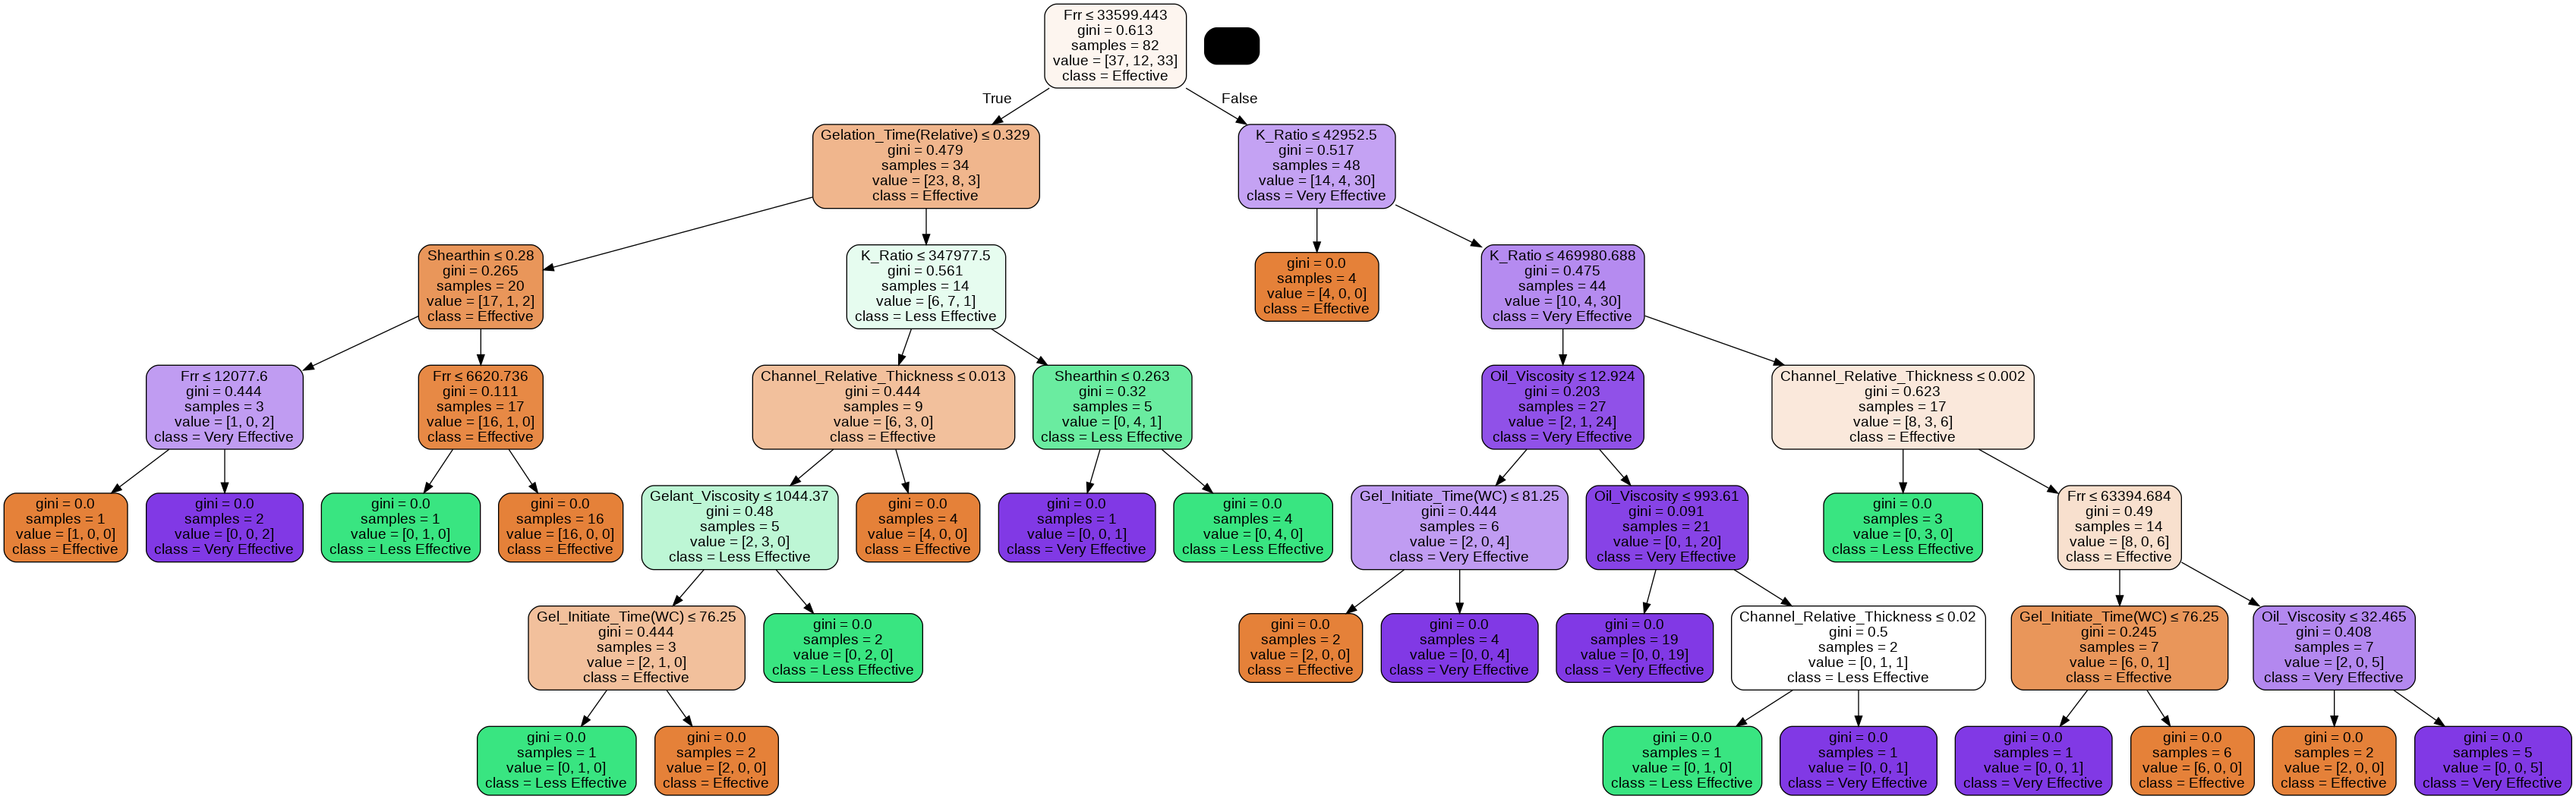

In [99]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
cols_names=X.columns
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = cols_names,class_names=class_name)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())